## Setup

### Import Libraries, Set up device, Set up seeds

In [83]:
# Imports
import gpytorch
import torch
import numpy as np
import matplotlib.pyplot as plt
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.utils import standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from tqdm import trange
import pandas as pd
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.models import ApproximateGP
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood, StudentTLikelihood
from gpytorch.mlls import VariationalELBO
import math

# check for MPS and CUDA device availability
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS device found, setting as device.")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA device found, setting as device.")
else:
    device = torch.device("cpu")
    print("Neither MPS nor CUDA device found. Using default device (CPU).")


# set the seed for all random use
def set_seeds(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seeds(22)
seed = 22

# Initial setup
training_iterations = 20
num_initial_points = 3
num_new_samples_per_iteration = 1  # Change this to your desired number of new samples per iteration
total_samples = 200
acqFunc = "UCB"  # Change this to your desired acquisition function, UCB or EI
max_or_min = 'max'  # Change this to 'max' for maximization and 'min' for minimization

CUDA device found, setting as device.


### Sin wave objective function with noise and outliers added

In [84]:
# Create the training data
set_seeds(0)
X = np.linspace(0.0, np.pi * 2, total_samples)[:, None]
Y = np.sin(X)
cauchy_noise = np.random.standard_cauchy(Y.shape) * 0.06
Yc = Y + cauchy_noise
Yc = Yc/Yc.max()
X = X/X.max()
# Slightly noisy data
Yc[75:80] += 1

### Cauchy distribution with noise

In [85]:
# Step 1: Define the mixture of Cauchy distributions
def mixture_cauchy_function(x, x0s=[0], gammas=[1], weights=[1]):
    assert len(x0s) == len(gammas) == len(weights), "Length of parameters must match"
    mixture = np.zeros_like(x)
    for x0, gamma, weight in zip(x0s, gammas, weights):
        mixture += weight * (1 / (np.pi * gamma * (1 + ((x - x0) / gamma) ** 2)))
    return mixture / np.sum(weights)

# Step 2: Sample 200 points from the function
np.random.seed(0)  # For reproducibility
X = np.linspace(-10, 10, total_samples)
x0s = [0, 0, 0]  # Location parameters
gammas = [1, 3, 5]  # Scale parameters for heavier tails
weights = [1, 1, 1]  # Equal weights for simplicity
Y = mixture_cauchy_function(X, x0s, gammas, weights)

# Step 3: Add noise to the sampled points
cauchy_noise = np.random.standard_cauchy(Y.shape) * 0.01
Yc = Y + cauchy_noise
Yc = Yc/Yc.max()
X = X/X.max()

# Slightly noisy data
Yc[40:45] += 0

### Student-T Process Model

In [86]:
class STP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=False
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)

        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### Exact Gaussian Process Model

In [87]:
class ExactGP(gpytorch.models.ExactGP):
    def __init__(self, x_train, y_train, likelihood):
        # build the model using the ExactGP model from gpytorch
        super(ExactGP, self).__init__(x_train, y_train, likelihood)

        # use a constant mean, this value can be learned from the dataset
        self.mean_module = gpytorch.means.ConstantMean()

        # automatically determine the number of dimensions for the ARD kernel
        num_dimensions = x_train.shape[0]

        # use a scaled Matern kernel, the ScaleKernel allows the kernel to learn a scale factor for the dataset
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=2.5,ard_num_dims=num_dimensions))
            
        # set the number of outputs 
        self.num_outputs = 1

    def forward(self, x):
        # forward pass of the model

        # compute the mean and covariance of the model 
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)

        # return the MultivariateNormal distribution of the mean and covariance 
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### Variational Gaussian Process Model

In [88]:
class VariationalGP(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super(VariationalGP, self).__init__(variational_strategy)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel(ard_num_dims=inducing_points.size(0)))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### Acquisition Functions

In [89]:
# Upper Confidence Bound
def UCB(mean, std, beta):
    return mean + beta * std

def LCB(mean, std, beta):
    return mean - beta * std

# Expected Improvement
def EImin(mean, std, best_observed):
    z = (best_observed - mean) / std
    return (best_observed - mean) * torch.distributions.Normal(0, 1).cdf(z) + std * torch.distributions.Normal(0, 1).log_prob(z)

def EImax(mean, std, best_observed):
    z = (mean - best_observed) / std
    return (mean - best_observed) * torch.distributions.Normal(0, 1).cdf(z) + std * torch.distributions.Normal(0, 1).log_prob(z)

## Preprocessing 

In [90]:
class TorchStandardScaler:
    def fit(self, x):
        x = x.clone()
        # calculate mean and std of the tensor
        self.mean = x.mean(0, keepdim=True)
        self.std = x.std(0, unbiased=False, keepdim=True)
    def transform(self, x):
        x = x.clone()
        # standardize the tensor
        x -= self.mean
        x /= (self.std + 1e-10)
        return x
    def fit_transform(self, x):
        # copy the tensor as to not modify the original 
        x = x.clone()
        # calculate mean and std of the tensor
        self.mean = x.mean(0, keepdim=True)
        self.std = x.std(0, unbiased=False, keepdim=True)
        # standardize the tensor
        x -= self.mean
        x /= (self.std + 1e-10)
        return x
    
class TorchNormalizer:
    def fit(self, x):
        # calculate the maximum value and the minimum value of the tensor
        self.max = torch.max(x, dim=0).values
        self.min = torch.min(x, dim=0).values

    def transform(self, x):
        # normalize the tensor
        return (x.clone() - self.min) / (self.max - self.min)

    def fit_transform(self, x):
        # calculate the maximum value and the minimum value of the tensor
        self.max = torch.max(x, dim=0).values
        self.min = torch.min(x, dim=0).values
        # normalize the tensor
        return (x.clone() - self.min) / (self.max - self.min)

### Randomly initialize training data


In [91]:
train_x = torch.from_numpy(X.ravel()).to(dtype=torch.float64)
train_y = torch.from_numpy(Yc.ravel()).to(dtype=torch.float64)

indicesSTP = torch.randperm(total_samples)[:num_initial_points]
indicesEGP = indicesSTP
indicesVGP = indicesSTP

train_xSTP = train_x[indicesSTP]
train_ySTP = train_y[indicesSTP]
train_xEGP = train_xSTP
train_yEGP = train_ySTP
train_xVGP = train_xSTP
train_yVGP = train_ySTP
initialPoints = train_xSTP
initialPointsy = train_ySTP

TorchStd = TorchStandardScaler()
TorchStd.fit(train_x)
TorchNorm = TorchNormalizer()
TorchNorm.fit(train_x)

N = len(train_x)

n_top = int(math.ceil(N * 0.05))

# find the top 5% of the samples
if max_or_min == 'max':
    train_y_df = pd.DataFrame(train_y.numpy(), columns=[0])
    top_samples = train_y_df.nlargest(n_top, train_y_df.columns[0], keep='first').iloc[:, 0].values.tolist()
    print(f"Number of of top 5% samples: {len(top_samples)}")
    print(f"Top 5% samples: {top_samples}")
elif max_or_min == 'min':
    train_y_df = pd.DataFrame(train_y.numpy(), columns=[0])
    top_samples = train_y_df.nsmallest(n_top, train_y_df.columns[0], keep='first').iloc[:, 0].values.tolist()
    print(f"Number of of top 5% samples: {len(top_samples)}")
    print(f"Top 5% samples: {top_samples}")

def TopSamplesAmnt(y, top_samples):
    return len([i for i in y if i in top_samples]) / len(top_samples)

Number of of top 5% samples: 10
Top 5% samples: [1.0, 0.09581578861610801, 0.09540643738523687, 0.09496256596063775, 0.09465986763569254, 0.09098723181477605, 0.0885928315274403, 0.08312657059409323, 0.08161741292972068, 0.08088151695564628]


## Bayesian Optimization Loops

### Student-T Process Optimization

In [92]:
iterationSTP = [0]
topSTP = [0]
set_seeds(22)


if max_or_min == "max":
    # Identify indices of samples not in the top 5%
    # Calculate the threshold for the top 5%
    top_5_percent_threshold = torch.quantile(train_y, 0.95)
    non_top_5_indices = (train_y < top_5_percent_threshold).nonzero(as_tuple=True)[0]
elif max_or_min == "min":
    # Identify indices of samples not in the top 5%
    # Calculate the threshold for the top 5%
    top_5_percent_threshold = torch.quantile(train_y, 0.05)
    non_top_5_indices = (train_y > top_5_percent_threshold).nonzero(as_tuple=True)[0]

# Randomly sample from these non-top-5% indices
indicesSTP = torch.randperm(len(non_top_5_indices))[:num_initial_points]
indicesSTP = non_top_5_indices[indicesSTP]

train_xSTP = train_x[indicesSTP]
train_ySTP = train_y[indicesSTP]

print(f"Seed: {seed}")
print(f"Initial points: {train_xSTP}")

while topSTP[-1] < 100:

    iterationSTP.append(iterationSTP[-1] + 1)
    # standardize the initial inputs and outputs before
    train_xSTP = TorchStd.transform(train_xSTP)
    train_ySTP = TorchStandardScaler().fit_transform(train_ySTP).flatten() # Ensure y is 1-dimensional

    #def train_and_test_approximate_gp(objective_function_cls):
    model = STP(train_xSTP).to(dtype=torch.float64)
    #likelihood = gpytorch.likelihoods.GaussianLikelihood()
    likelihood = gpytorch.likelihoods.StudentTLikelihood()
    objective_function = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_ySTP.numel())
    # replace with gpytorch mll
    optimizer = torch.optim.Adam(list(model.parameters()) + list(likelihood.parameters()), lr=0.1)

    # Train
    model.train()
    #put it into training mode
    likelihood.train()

    for _ in range(50):
        output = model(train_xSTP)
        loss = -objective_function(output, train_ySTP)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


    # Test
    model.eval()
    likelihood.eval()

    # works wtih the variational distribution
    with gpytorch.settings.num_likelihood_samples(512):
        observed_pred = likelihood(model(TorchStd.transform(train_x)))

    samples = observed_pred.sample()


    # use as inputs to EI
    meanSTP = samples.mean(dim=0)
    stdSTP = samples.std(dim=0)
    best = train_ySTP.max()

        

    if acqFunc == "UCB":
        # Select new points using UCB
        ucb_values = UCB(meanSTP, stdSTP, 1.96)
        ucb_values[indicesSTP] = -float('inf')
        indicesSTP = torch.cat([indicesSTP, ucb_values.argmax().unsqueeze(0)])

    elif acqFunc == "LCB":
        # Select new points using EI
        lcb_values = LCB(meanSTP, stdSTP, best)
        lcb_values[indicesSTP] = -float('inf')
        indicesSTP = torch.cat([indicesSTP, lcb_values.argmax().unsqueeze(0)])

    elif acqFunc == "EImin":
        # Select new points using EI
        ei_min_values = EImin(meanSTP, stdSTP, best)
        ei_min_values[indicesSTP] = -float('inf')
        indicesSTP = torch.cat([indicesSTP, ei_min_values.argmax().unsqueeze(0)])

    elif acqFunc == "EImax":
        # Select new points using EI
        ei_max_values = EImax(meanSTP, stdSTP, best)
        ei_max_values[indicesSTP] = -float('inf')
        indicesSTP = torch.cat([indicesSTP, ei_max_values.argmax().unsqueeze(0)])
    else:
        print("Please change the acquisition function to UCB, LCB, EImax, or EImin in the setup")
        raise ValueError("Invalid acquisition function specified")

    # Convert new_indices to a tensor
    # Add the new points to the training data
    train_xSTP = train_x[indicesSTP]
    train_ySTP = train_y[indicesSTP]
    topSTP.append(TopSamplesAmnt(train_ySTP, top_samples)*100)


    if iterationSTP[-1] > len(train_x) - num_initial_points:
        print("Maximum number of iterations exceeded, breaking loop.")
        print(f'Iterations {iterationSTP[-1]}')
        break
    print(f"Iteration {iterationSTP[-1]}")
    print(f"New points: {train_xSTP[-1]}")
    print(f"Top 5%: {topSTP[-1]}")
        

print(f'Iterations {iterationSTP[-1]}')

Seed: 22
Initial points: tensor([-0.2060, -0.2864,  0.4372], dtype=torch.float64)
Iteration 1
New points: -0.19597989949748734
Top 5%: 0.0
Iteration 2
New points: -0.21608040201005024
Top 5%: 0.0
Iteration 3
New points: -0.18592964824120592
Top 5%: 10.0
Iteration 4
New points: -0.3366834170854271
Top 5%: 10.0
Iteration 5
New points: -0.17587939698492452
Top 5%: 10.0
Iteration 6
New points: -0.08542713567839186
Top 5%: 10.0
Iteration 7
New points: 0.8793969849246231
Top 5%: 10.0
Iteration 8
New points: 0.045226130653266416
Top 5%: 10.0
Iteration 9
New points: 0.7085427135678394
Top 5%: 10.0
Iteration 10
New points: -0.6482412060301508
Top 5%: 10.0
Iteration 11
New points: 0.969849246231156
Top 5%: 10.0
Iteration 12
New points: 0.07537688442211063
Top 5%: 10.0
Iteration 13
New points: 0.15577889447236187
Top 5%: 10.0
Iteration 14
New points: -0.9899497487437185
Top 5%: 10.0
Iteration 15
New points: -0.5778894472361809
Top 5%: 10.0
Iteration 16
New points: -0.055276381909547645
Top 5%: 10

### Exact Gaussian Process Optimization

In [93]:
iterationEGP = [0]
topEGP = [0]
set_seeds(22)

if max_or_min == "max":
    # Identify indices of samples not in the top 5%
    top_5_percent_threshold = torch.quantile(train_y, 0.95)
    non_top_5_indices = (train_y < top_5_percent_threshold).nonzero(as_tuple=True)[0]
elif max_or_min == "min":
    # Identify indices of samples not in the top 5%
    top_5_percent_threshold = torch.quantile(train_y, 0.05)
    non_top_5_indices = (train_y > top_5_percent_threshold).nonzero(as_tuple=True)[0]

# Randomly sample from these non-top-5% indices
indicesEGP = torch.randperm(len(non_top_5_indices))[:num_initial_points]
indicesEGP = non_top_5_indices[indicesEGP]

train_xEGP = train_x[indicesEGP]
train_yEGP = train_y[indicesEGP]

print(f"Seed: {seed}")
print(f"Initial points: {train_xEGP}")

while topEGP[-1] < 100:
    iterationEGP.append(iterationEGP[-1] + 1)
    # standardize the initial inputs and outputs before
    train_xEGP = TorchStd.transform(train_xEGP)
    train_yEGP = TorchStandardScaler().fit_transform(train_yEGP).flatten()
    
    # optimize the model
    # use a half normal prior for the noise to find a Gaussian likelihood
    likelihood = GaussianLikelihood(noise_prior=gpytorch.priors.HalfNormalPrior(0.01))

    # using the found likelihood, create a GP model
    gp = ExactGP(train_xEGP, train_yEGP, likelihood)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp)

    # fit the model by maximizing the marginal log likelihood
    gp.train()
    likelihood.train()
    fit_gpytorch_mll(mll)

    gp.eval()
    likelihood.eval()

    # predict from candidate pool
    with torch.no_grad():
        pred = gp(TorchStd.transform(train_x)) # predict values for all candidates

    meanEGP = pred.mean
    stdEGP = pred.stddev
    best = train_yEGP.max()
    

    if acqFunc == "UCB":
        # Select new points using UCB
        ucb_values = UCB(meanEGP, stdEGP, 1.96)
        ucb_values[indicesEGP] = -float('inf')
        indicesEGP = torch.cat([indicesEGP, ucb_values.argmax().unsqueeze(0)])

    elif acqFunc == "LCB":
        # Select new points using EI
        lcb_values = LCB(meanEGP, stdEGP, best)
        lcb_values[indicesEGP] = -float('inf')
        indicesEGP = torch.cat([indicesEGP, lcb_values.argmax().unsqueeze(0)])

    elif acqFunc == "EImin":
        # Select new points using EI
        ei_min_values = EImin(meanEGP, stdEGP, best)
        ei_min_values[indicesEGP] = -float('inf')
        indicesEGP = torch.cat([indicesEGP, ei_min_values.argmax().unsqueeze(0)])

    elif acqFunc == "EImax":
        # Select new points using EI
        ei_max_values = EImax(meanEGP, stdEGP, best)
        ei_max_values[indicesEGP] = -float('inf')
        indicesEGP = torch.cat([indicesEGP, ei_max_values.argmax().unsqueeze(0)])
    else:
        print("Please change the acquisition function to UCB, LCB, EImax, or EImin in the setup")
        raise ValueError("Invalid acquisition function specified")
    

    # add the new point to the training data
    train_xEGP = train_x[indicesEGP]
    train_yEGP = train_y[indicesEGP]
    topEGP.append(TopSamplesAmnt(train_yEGP, top_samples)*100)
    
    if iterationEGP[-1] > len(train_x) - num_initial_points:
        print("Maximum number of iterations exceeded, breaking loop.")
        print(f'Iterations {iterationEGP[-1]}')
        break

    print(f"Iteration {iterationEGP[-1]}")
    print(f"New points: {train_xEGP[-1]}")
    print(f"Top 5%: {topEGP[-1]}")

print(f'Iterations {iterationEGP[-1]}')


Seed: 22
Initial points: tensor([-0.2060, -0.2864,  0.4372], dtype=torch.float64)
Iteration 1
New points: -1.0
Top 5%: 0.0
Iteration 2
New points: -0.9899497487437185
Top 5%: 0.0
Iteration 3
New points: -0.9798994974874372
Top 5%: 0.0
Iteration 4
New points: -0.22613065326633164
Top 5%: 0.0
Iteration 5
New points: -0.18592964824120592
Top 5%: 10.0
Iteration 6
New points: -0.1658291457286431
Top 5%: 10.0
Iteration 7
New points: -0.19597989949748734
Top 5%: 10.0
Iteration 8
New points: -0.17587939698492452
Top 5%: 10.0
Iteration 9
New points: -0.21608040201005024
Top 5%: 10.0
Iteration 10
New points: -0.1557788944723617
Top 5%: 10.0
Iteration 11
New points: -0.1457286432160803
Top 5%: 10.0
Iteration 12
New points: -0.1356783919597989
Top 5%: 10.0
Iteration 13
New points: -0.11557788944723608
Top 5%: 10.0
Iteration 14
New points: -0.10552763819095468
Top 5%: 10.0
Iteration 15
New points: -0.1256281407035175
Top 5%: 10.0
Iteration 16
New points: -0.23618090452261303
Top 5%: 10.0
Iteration 

c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(


Iteration 130
New points: -0.8592964824120604
Top 5%: 90.0
Iteration 131
New points: -0.8492462311557789
Top 5%: 90.0


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(


Iteration 132
New points: -0.8291457286432161
Top 5%: 90.0
Iteration 133
New points: -0.457286432160804
Top 5%: 90.0
Iteration 134
New points: -0.3969849246231155
Top 5%: 90.0
Iteration 135
New points: -0.7085427135678393
Top 5%: 90.0
Iteration 136
New points: -0.6884422110552764
Top 5%: 90.0
Iteration 137
New points: 0.2864321608040202
Top 5%: 90.0
Iteration 138
New points: -0.3165829145728643
Top 5%: 90.0
Iteration 139
New points: -0.37688442211055273
Top 5%: 90.0
Iteration 140
New points: 0.38693467336683424
Top 5%: 90.0
Iteration 141
New points: -0.507537688442211
Top 5%: 90.0
Iteration 142
New points: -0.5477386934673366
Top 5%: 90.0
Iteration 143
New points: 0.46733668341708545
Top 5%: 90.0
Iteration 144
New points: -0.7889447236180904
Top 5%: 90.0
Iteration 145
New points: 0.44723618090452266
Top 5%: 90.0
Iteration 146
New points: 0.7386934673366834
Top 5%: 90.0
Iteration 147
New points: -0.6180904522613065
Top 5%: 90.0
Iteration 148
New points: -0.6582914572864322
Top 5%: 90.0


### Variational Gaussian Process Optimization

In [94]:
iterationVGP = [0]
topVGP = [0]
set_seeds(22)


if max_or_min == "max":
    # Identify indices of samples not in the top 5%
    # Calculate the threshold for the top 5%
    top_5_percent_threshold = torch.quantile(train_y, 0.95)
    non_top_5_indices = (train_y < top_5_percent_threshold).nonzero(as_tuple=True)[0]
elif max_or_min == "min":
    # Identify indices of samples not in the top 5%
    # Calculate the threshold for the top 5%
    top_5_percent_threshold = torch.quantile(train_y, 0.05)
    non_top_5_indices = (train_y > top_5_percent_threshold).nonzero(as_tuple=True)[0]

# Randomly sample from these non-top-5% indices
indicesVGP = torch.randperm(len(non_top_5_indices))[:num_initial_points]
indicesVGP = non_top_5_indices[indicesVGP]

train_xVGP = train_x[indicesVGP]
train_yVGP = train_y[indicesVGP]

print(f"Seed: {seed}")
print(f"Initial points: {train_xSTP}")

while topVGP[-1] < 100:
    
    iterationVGP.append(iterationVGP[-1] + 1)
    # standardize the initial inputs and outputs before
    train_xVGP = TorchStd.transform(train_xVGP)
    train_yVGP = TorchStandardScaler().fit_transform(train_yVGP).flatten()

    #def train_and_test_approximate_gp(objective_function_cls):
    model = VariationalGP(train_xVGP).to(dtype=torch.float64)

    likelihood = GaussianLikelihood()
    objective_function = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_yVGP.numel())
    # replace with gpytorch mll
    optimizer = torch.optim.Adam(list(model.parameters()) + list(likelihood.parameters()), lr=0.1)

    # Train
    model.train()
    #put it into training mode
    likelihood.train()

    for _ in range(50):
        output = model(train_xVGP)
        loss = -objective_function(output, train_yVGP)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    # Test
    model.eval()
    likelihood.eval()

    # works wtih the variational distribution
    with torch.no_grad():
        pred = model(TorchStd.transform(train_x))

    # get the mean and standard deviation of the samples
    meanVGP = pred.mean
    stdVGP = pred.stddev
    
    # Calculate the best observed value for EI
    best_observed_value = train_yVGP.min()
    
    if acqFunc == "UCB":
        # Select new points using UCB
        ucb_values = UCB(meanVGP, stdVGP, 1.96)
        ucb_values[indicesVGP] = -float('inf')
        indicesVGP = torch.cat([indicesVGP, ucb_values.argmax().unsqueeze(0)])

    elif acqFunc == "LCB":
        # Select new points using EI
        lcb_values = LCB(meanVGP, stdVGP, best)
        lcb_values[indicesVGP] = -float('inf')
        indicesVGP = torch.cat([indicesVGP, lcb_values.argmax().unsqueeze(0)])

    elif acqFunc == "EImin":
        # Select new points using EI
        ei_min_values = EImin(meanVGP, stdVGP, best)
        ei_min_values[indicesVGP] = -float('inf')
        indicesVGP = torch.cat([indicesVGP, ei_min_values.argmax().unsqueeze(0)])

    elif acqFunc == "EImax":
        # Select new points using EI
        ei_max_values = EImax(meanVGP, stdVGP, best)
        ei_max_values[indicesVGP] = -float('inf')
        indicesVGP = torch.cat([indicesVGP, ei_max_values.argmax().unsqueeze(0)])
    else:
        print("Please change the acquisition function to UCB, LCB, EImax, or EImin in the setup")
        raise ValueError("Invalid acquisition function specified")

    # Convert new_indices to a tensor
    # Add the new points to the training data
    train_xVGP = train_x[indicesVGP]
    train_yVGP = train_y[indicesVGP]
    topVGP.append(TopSamplesAmnt(train_yVGP, top_samples)*100)

    if iterationVGP[-1] > len(train_x) - num_initial_points:
        print("Maximum number of iterations exceeded, breaking loop.")
        print(f"Reached {topVGP[-1]}%")
        break
    print(f"Iteration {iterationVGP[-1]}")
    print(f"New points: {train_xVGP[-1]}")
    print(f"Top 5%: {topVGP[-1]}")

print(f'Iterations {iterationVGP[-1]}')

Seed: 22
Initial points: tensor([-0.2060, -0.2864,  0.4372, -0.1960, -0.2161, -0.1859, -0.3367, -0.1759,
        -0.0854,  0.8794,  0.0452,  0.7085, -0.6482,  0.9698,  0.0754,  0.1558,
        -0.9899, -0.5779, -0.0553, -0.1457, -0.1558, -0.0151, -0.0251,  0.0352,
         0.9397, -0.0452,  0.0653,  0.1357,  0.0854, -0.8191, -0.0050, -0.7789,
         0.0151, -0.0352, -0.0653,  0.8995,  0.0050,  0.0955,  0.3266,  0.3970,
        -0.3166,  0.2261,  0.3467, -0.1256,  0.2060,  0.9899,  0.0553,  0.3869,
        -0.5276,  0.1457, -0.3266, -0.1156, -0.9397, -0.6985,  0.4673, -0.7286,
         0.8593,  0.0251,  0.1960,  0.2864, -0.0754, -0.3869, -0.9095,  0.9296,
        -0.2462, -0.4975,  0.1256,  0.1156, -0.8794, -0.8492, -0.1055, -0.0955,
        -0.6382, -0.4372,  0.8291,  0.3166,  0.1759, -0.5678, -0.1658,  0.4472,
         0.1055, -0.8392, -0.5980,  0.5075,  0.3367,  0.2563, -0.7688, -0.4874,
         0.9598, -0.8090,  0.8090], dtype=torch.float64)
Iteration 1
New points: -0.22613065326

## Visualization

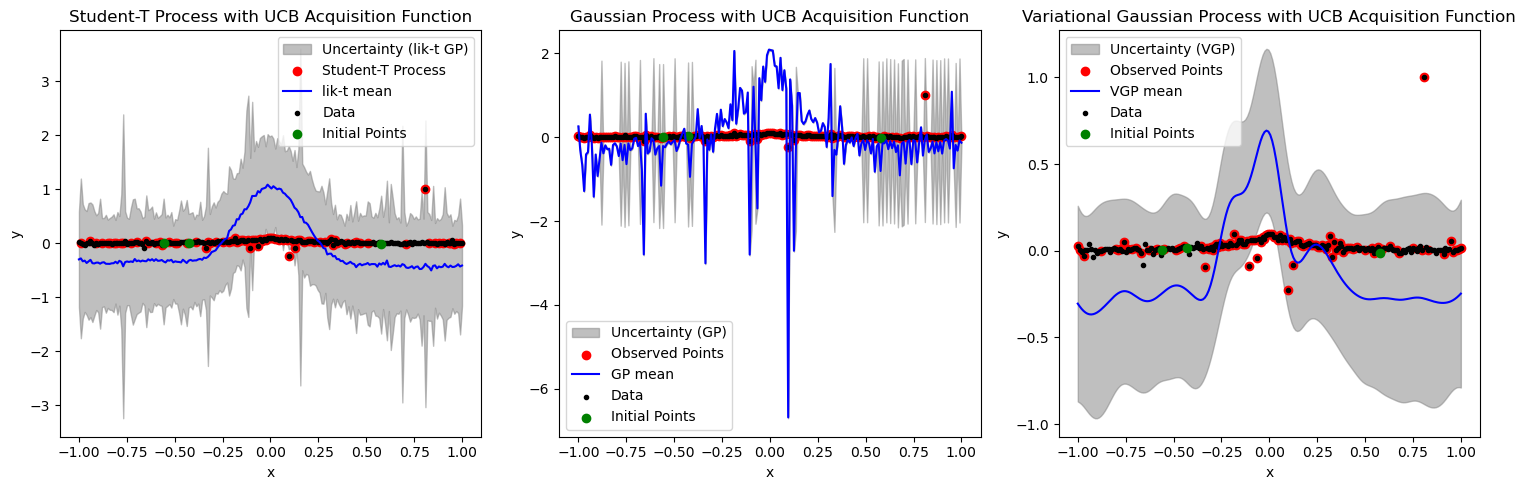

In [96]:
# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# First subplot: Student-T Process
ax1.fill_between(train_x.numpy(), (meanSTP - 2*stdSTP).numpy(), (meanSTP + 2*stdSTP).numpy(), color='grey', alpha=0.5, label='Uncertainty (lik-t GP)')
ax1.scatter(train_xSTP.numpy(), train_ySTP.numpy(), c='red', label="Student-T Process")
ax1.plot(train_x.numpy(), meanSTP.numpy(), 'b-', label="lik-t mean")
ax1.scatter(train_x.numpy(), train_y.numpy(), c='k', marker='.', label="Data")
ax1.scatter(initialPoints, initialPointsy, c='green', marker='o', label="Initial Points")
ax1.legend(loc="best")
ax1.set(xlabel="x", ylabel="y", title="Student-T Process with "+ acqFunc + " Acquisition Function")

# Second subplot: Gaussian Process
ax2.fill_between(train_x.numpy(), (meanEGP - 2*stdEGP).numpy(), (meanEGP + 2*stdEGP).numpy(), color='grey', alpha=0.5, label='Uncertainty (GP)')
ax2.scatter(train_xEGP.numpy(), train_yEGP.numpy(), c='red', label="Observed Points")
ax2.plot(train_x.numpy(), meanEGP.numpy(), 'b-', label="GP mean")
ax2.scatter(train_x.numpy(), train_y.numpy(), c='k', marker='.', label="Data")
ax2.scatter(initialPoints, initialPointsy, c='green', marker='o', label="Initial Points")
ax2.legend(loc="best")
ax2.set(xlabel="x", ylabel="y", title="Gaussian Process with "+ acqFunc + " Acquisition Function")

# Third subplot: Variational Gaussian Process
ax3.fill_between(train_x.numpy(), (meanVGP - 2*stdVGP).numpy(), (meanVGP + 2*stdVGP).numpy(), color='grey', alpha=0.5, label='Uncertainty (VGP)')
ax3.scatter(train_xVGP.numpy(), train_yVGP.numpy(), c='red', label="Observed Points")
ax3.plot(train_x.numpy(), meanVGP.numpy(), 'b-', label="VGP mean")
ax3.scatter(train_x.numpy(), train_y.numpy(), c='k', marker='.', label="Data")
ax3.scatter(initialPoints, initialPointsy, c='green', marker='o', label="Initial Points")
ax3.legend(loc="best")
ax3.set(xlabel="x", ylabel="y", title="Variational Gaussian Process with " + acqFunc + " Acquisition Function")

# Adjust layout
plt.tight_layout()
plt.show()
